In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'relu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

relu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:24 - loss: 0.0757 - STD: 0.0115 - MAE: 0.2600

 4/74 [>.............................] - ETA: 1s - loss: 0.0525 - STD: 0.0052 - MAE: 0.2067  

 7/74 [=>............................] - ETA: 1s - loss: 0.0791 - STD: 0.0081 - MAE: 0.2308

10/74 [===>..........................] - ETA: 1s - loss: 0.0653 - STD: 0.0082 - MAE: 0.2065

14/74 [====>.........................] - ETA: 1s - loss: 0.0606 - STD: 0.0059 - MAE: 0.2045

18/74 [======>.......................] - ETA: 0s - loss: 0.0581 - STD: 0.0046 - MAE: 0.2036

21/74 [=======>......................] - ETA: 0s - loss: 0.0569 - STD: 0.0040 - MAE: 0.2031

24/74 [========>.....................] - ETA: 0s - loss: 0.0559 - STD: 0.0035 - MAE: 0.2027

27/74 [=========>....................] - ETA: 0s - loss: 0.0551 - STD: 0.0031 - MAE: 0.2023

30/74 [===========>..................] - ETA: 1s - loss: 0.0546 - STD: 0.0028 - MAE: 0.2019

33/74 [============>.................] - ETA: 1s - loss: 0.0541 - STD: 0.0025 - MAE: 0.2017

37/74 [==============>...............] - ETA: 1s - loss: 0.0536 - STD: 0.0022 - MAE: 0.2016

41/74 [===============>..............] - ETA: 0s - loss: 0.0531 - STD: 0.0020 - MAE: 0.2014

44/74 [================>.............] - ETA: 0s - loss: 0.0529 - STD: 0.0019 - MAE: 0.2013

47/74 [==================>...........] - ETA: 0s - loss: 0.0527 - STD: 0.0018 - MAE: 0.2013

50/74 [===================>..........] - ETA: 0s - loss: 0.0525 - STD: 0.0017 - MAE: 0.2012

53/74 [====================>.........] - ETA: 0s - loss: 0.0523 - STD: 0.0016 - MAE: 0.2012

56/74 [=====================>........] - ETA: 0s - loss: 0.0521 - STD: 0.0015 - MAE: 0.2011

59/74 [======================>.......] - ETA: 0s - loss: 0.0519 - STD: 0.0014 - MAE: 0.2010

62/74 [========================>.....] - ETA: 0s - loss: 0.0518 - STD: 0.0013 - MAE: 0.2010

65/74 [=========================>....] - ETA: 0s - loss: 0.0517 - STD: 0.0013 - MAE: 0.2009

68/74 [==========================>...] - ETA: 0s - loss: 0.0516 - STD: 0.0012 - MAE: 0.2008

71/74 [===========================>..] - ETA: 0s - loss: 0.0515 - STD: 0.0012 - MAE: 0.2008

74/74 [==============================] - ETA: 0s - loss: 0.0514 - STD: 0.0011 - MAE: 0.2008

74/74 [==============================] - 4s 33ms/step - loss: 0.0514 - STD: 0.0011 - MAE: 0.2008 - val_loss: 0.0481 - val_STD: 5.7815e-09 - val_MAE: 0.2017


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0492 - STD: 8.7071e-09 - MAE: 0.1997

 4/74 [>.............................] - ETA: 1s - loss: 0.0496 - STD: 8.7635e-09 - MAE: 0.2006

 7/74 [=>............................] - ETA: 1s - loss: 0.0493 - STD: 8.7023e-09 - MAE: 0.2001

10/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 8.7457e-09 - MAE: 0.2001

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 8.7410e-09 - MAE: 0.2001

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 8.7209e-09 - MAE: 0.1999

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 8.7078e-09 - MAE: 0.1999

22/74 [=======>......................] - ETA: 0s - loss: 0.0493 - STD: 8.6918e-09 - MAE: 0.2001

26/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.6902e-09 - MAE: 0.2000

29/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.6813e-09 - MAE: 0.1999

32/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.6678e-09 - MAE: 0.1999

35/74 [=============>................] - ETA: 0s - loss: 0.0492 - STD: 8.6622e-09 - MAE: 0.1999

38/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.6863e-09 - MAE: 0.1999

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.6890e-09 - MAE: 0.1999

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.6886e-09 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.6947e-09 - MAE: 0.1999

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 8.6901e-09 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.6836e-09 - MAE: 0.2000

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.6874e-09 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.6644e-09 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.6655e-09 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 8.6731e-09 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.6639e-09 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.6685e-09 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.6707e-09 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 8.6707e-09 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 5.7343e-09 - val_MAE: 0.2017


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0483 - STD: 9.0618e-09 - MAE: 0.1979

 4/74 [>.............................] - ETA: 1s - loss: 0.0494 - STD: 8.8018e-09 - MAE: 0.2003

 7/74 [=>............................] - ETA: 1s - loss: 0.0492 - STD: 8.7633e-09 - MAE: 0.2000

10/74 [===>..........................] - ETA: 1s - loss: 0.0489 - STD: 8.8328e-09 - MAE: 0.1994

13/74 [====>.........................] - ETA: 1s - loss: 0.0490 - STD: 8.7775e-09 - MAE: 0.1996

16/74 [=====>........................] - ETA: 1s - loss: 0.0491 - STD: 8.8071e-09 - MAE: 0.1997

19/74 [======>.......................] - ETA: 1s - loss: 0.0491 - STD: 8.8040e-09 - MAE: 0.1998

22/74 [=======>......................] - ETA: 0s - loss: 0.0491 - STD: 8.7988e-09 - MAE: 0.1998

25/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 8.7861e-09 - MAE: 0.1999

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.7690e-09 - MAE: 0.1998

31/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 8.7552e-09 - MAE: 0.1999

34/74 [============>.................] - ETA: 0s - loss: 0.0493 - STD: 8.7624e-09 - MAE: 0.2000

37/74 [==============>...............] - ETA: 0s - loss: 0.0493 - STD: 8.7897e-09 - MAE: 0.2000

40/74 [===============>..............] - ETA: 0s - loss: 0.0493 - STD: 8.8042e-09 - MAE: 0.2000

43/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.8109e-09 - MAE: 0.2000

46/74 [=================>............] - ETA: 0s - loss: 0.0492 - STD: 8.8058e-09 - MAE: 0.2000

49/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 8.8157e-09 - MAE: 0.2000

52/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 8.8111e-09 - MAE: 0.2000

55/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 8.8144e-09 - MAE: 0.2000

58/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 8.8100e-09 - MAE: 0.2000

61/74 [=======================>......] - ETA: 0s - loss: 0.0492 - STD: 8.7986e-09 - MAE: 0.2000

64/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 8.8077e-09 - MAE: 0.2000

67/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 8.8082e-09 - MAE: 0.2000

70/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 8.8181e-09 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 8.8169e-09 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 8.8169e-09 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 5.8779e-09 - val_MAE: 0.2017


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0491 - STD: 9.0241e-09 - MAE: 0.2000

 4/74 [>.............................] - ETA: 1s - loss: 0.0490 - STD: 9.2375e-09 - MAE: 0.1998

 7/74 [=>............................] - ETA: 1s - loss: 0.0494 - STD: 9.0612e-09 - MAE: 0.2006

10/74 [===>..........................] - ETA: 1s - loss: 0.0495 - STD: 9.0129e-09 - MAE: 0.2006

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 8.9539e-09 - MAE: 0.2003

16/74 [=====>........................] - ETA: 1s - loss: 0.0493 - STD: 8.8996e-09 - MAE: 0.2002

19/74 [======>.......................] - ETA: 1s - loss: 0.0493 - STD: 8.9369e-09 - MAE: 0.2002

22/74 [=======>......................] - ETA: 0s - loss: 0.0493 - STD: 8.9374e-09 - MAE: 0.2003

25/74 [=========>....................] - ETA: 0s - loss: 0.0493 - STD: 8.9186e-09 - MAE: 0.2002

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 8.9454e-09 - MAE: 0.2001

31/74 [===========>..................] - ETA: 0s - loss: 0.0493 - STD: 8.9232e-09 - MAE: 0.2001

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 8.9515e-09 - MAE: 0.2001

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 8.9530e-09 - MAE: 0.2000

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 8.9436e-09 - MAE: 0.2000

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 8.9674e-09 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0493 - STD: 9.0022e-09 - MAE: 0.2000

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 8.9982e-09 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 9.0077e-09 - MAE: 0.1999

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 9.0077e-09 - MAE: 0.1999

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 9.0204e-09 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 9.0391e-09 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 9.0359e-09 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 9.0398e-09 - MAE: 0.2000

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 9.0445e-09 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 9.0609e-09 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 9.0609e-09 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 6.0598e-09 - val_MAE: 0.2017


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0494 - STD: 9.2090e-09 - MAE: 0.2001

 4/74 [>.............................] - ETA: 1s - loss: 0.0491 - STD: 9.0302e-09 - MAE: 0.1998

 7/74 [=>............................] - ETA: 1s - loss: 0.0492 - STD: 9.1120e-09 - MAE: 0.2000

10/74 [===>..........................] - ETA: 1s - loss: 0.0494 - STD: 9.1937e-09 - MAE: 0.2004

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 9.2129e-09 - MAE: 0.2001

16/74 [=====>........................] - ETA: 1s - loss: 0.0491 - STD: 9.2174e-09 - MAE: 0.1999

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 9.2349e-09 - MAE: 0.1999

22/74 [=======>......................] - ETA: 1s - loss: 0.0491 - STD: 9.2229e-09 - MAE: 0.1999

26/74 [=========>....................] - ETA: 0s - loss: 0.0491 - STD: 9.2423e-09 - MAE: 0.1999

29/74 [==========>...................] - ETA: 0s - loss: 0.0491 - STD: 9.2184e-09 - MAE: 0.1998

32/74 [===========>..................] - ETA: 0s - loss: 0.0491 - STD: 9.2314e-09 - MAE: 0.1999

35/74 [=============>................] - ETA: 0s - loss: 0.0492 - STD: 9.2655e-09 - MAE: 0.1999

38/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 9.2872e-09 - MAE: 0.2000

41/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 9.3082e-09 - MAE: 0.2000

44/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 9.3103e-09 - MAE: 0.2000

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 9.3167e-09 - MAE: 0.2000

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 9.3177e-09 - MAE: 0.2000

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 9.3211e-09 - MAE: 0.2000

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 9.3378e-09 - MAE: 0.2000

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 9.3365e-09 - MAE: 0.1999

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 9.3319e-09 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 9.3303e-09 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 9.3440e-09 - MAE: 0.1999

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 9.3499e-09 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 9.3619e-09 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 9.3619e-09 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 6.2818e-09 - val_MAE: 0.2017


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0493 - STD: 9.3719e-09 - MAE: 0.2000

 4/74 [>.............................] - ETA: 1s - loss: 0.0492 - STD: 9.3459e-09 - MAE: 0.2000

 7/74 [=>............................] - ETA: 1s - loss: 0.0494 - STD: 9.4412e-09 - MAE: 0.2003

10/74 [===>..........................] - ETA: 1s - loss: 0.0493 - STD: 9.5242e-09 - MAE: 0.2000

13/74 [====>.........................] - ETA: 1s - loss: 0.0492 - STD: 9.5850e-09 - MAE: 0.1999

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 9.6013e-09 - MAE: 0.1999

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 9.5870e-09 - MAE: 0.1999

22/74 [=======>......................] - ETA: 0s - loss: 0.0491 - STD: 9.5955e-09 - MAE: 0.1997

25/74 [=========>....................] - ETA: 0s - loss: 0.0491 - STD: 9.5732e-09 - MAE: 0.1996

28/74 [==========>...................] - ETA: 0s - loss: 0.0491 - STD: 9.5724e-09 - MAE: 0.1996

32/74 [===========>..................] - ETA: 0s - loss: 0.0491 - STD: 9.5836e-09 - MAE: 0.1997

36/74 [=============>................] - ETA: 0s - loss: 0.0491 - STD: 9.6252e-09 - MAE: 0.1997

40/74 [===============>..............] - ETA: 0s - loss: 0.0491 - STD: 9.6215e-09 - MAE: 0.1997

44/74 [================>.............] - ETA: 0s - loss: 0.0491 - STD: 9.6225e-09 - MAE: 0.1997

47/74 [==================>...........] - ETA: 0s - loss: 0.0491 - STD: 9.6235e-09 - MAE: 0.1998

50/74 [===================>..........] - ETA: 0s - loss: 0.0491 - STD: 9.6443e-09 - MAE: 0.1998

53/74 [====================>.........] - ETA: 0s - loss: 0.0491 - STD: 9.6611e-09 - MAE: 0.1998

56/74 [=====================>........] - ETA: 0s - loss: 0.0491 - STD: 9.6743e-09 - MAE: 0.1999

59/74 [======================>.......] - ETA: 0s - loss: 0.0491 - STD: 9.6773e-09 - MAE: 0.1999

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 9.6832e-09 - MAE: 0.1999

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 9.6938e-09 - MAE: 0.1999

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 9.7083e-09 - MAE: 0.1999

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 9.7179e-09 - MAE: 0.2000

74/74 [==============================] - ETA: 0s - loss: 0.0492 - STD: 9.7213e-09 - MAE: 0.2000

74/74 [==============================] - 2s 20ms/step - loss: 0.0492 - STD: 9.7213e-09 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 6.5566e-09 - val_MAE: 0.2017


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0496 - STD: 9.9105e-09 - MAE: 0.2004

 4/74 [>.............................] - ETA: 1s - loss: 0.0491 - STD: 9.9870e-09 - MAE: 0.1996

 7/74 [=>............................] - ETA: 1s - loss: 0.0493 - STD: 9.9624e-09 - MAE: 0.2001

10/74 [===>..........................] - ETA: 1s - loss: 0.0492 - STD: 9.9000e-09 - MAE: 0.2000

13/74 [====>.........................] - ETA: 1s - loss: 0.0492 - STD: 9.9504e-09 - MAE: 0.1999

16/74 [=====>........................] - ETA: 1s - loss: 0.0493 - STD: 9.9808e-09 - MAE: 0.2001

19/74 [======>.......................] - ETA: 1s - loss: 0.0493 - STD: 9.9418e-09 - MAE: 0.2001

22/74 [=======>......................] - ETA: 0s - loss: 0.0493 - STD: 9.9872e-09 - MAE: 0.2001

26/74 [=========>....................] - ETA: 0s - loss: 0.0493 - STD: 1.0033e-08 - MAE: 0.2000

30/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 1.0049e-08 - MAE: 0.2000

34/74 [============>.................] - ETA: 0s - loss: 0.0493 - STD: 1.0039e-08 - MAE: 0.2001

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 1.0041e-08 - MAE: 0.2000

40/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 1.0045e-08 - MAE: 0.2000

43/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 1.0063e-08 - MAE: 0.2000

46/74 [=================>............] - ETA: 0s - loss: 0.0492 - STD: 1.0074e-08 - MAE: 0.2000

49/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 1.0068e-08 - MAE: 0.2000

52/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 1.0075e-08 - MAE: 0.2000

55/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 1.0083e-08 - MAE: 0.2000

58/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 1.0107e-08 - MAE: 0.2000

61/74 [=======================>......] - ETA: 0s - loss: 0.0492 - STD: 1.0125e-08 - MAE: 0.2000

64/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 1.0139e-08 - MAE: 0.2000

67/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 1.0145e-08 - MAE: 0.2000

70/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 1.0163e-08 - MAE: 0.2000

73/74 [============================>.] - ETA: 0s - loss: 0.0492 - STD: 1.0167e-08 - MAE: 0.2000

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 1.0175e-08 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 6.8847e-09 - val_MAE: 0.2017


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0493 - STD: 1.0656e-08 - MAE: 0.1999

 4/74 [>.............................] - ETA: 1s - loss: 0.0494 - STD: 1.0499e-08 - MAE: 0.2003

 7/74 [=>............................] - ETA: 1s - loss: 0.0494 - STD: 1.0457e-08 - MAE: 0.2003

10/74 [===>..........................] - ETA: 1s - loss: 0.0494 - STD: 1.0461e-08 - MAE: 0.2002

13/74 [====>.........................] - ETA: 1s - loss: 0.0493 - STD: 1.0455e-08 - MAE: 0.2002

16/74 [=====>........................] - ETA: 1s - loss: 0.0492 - STD: 1.0507e-08 - MAE: 0.2000

19/74 [======>.......................] - ETA: 1s - loss: 0.0492 - STD: 1.0496e-08 - MAE: 0.1999

22/74 [=======>......................] - ETA: 0s - loss: 0.0492 - STD: 1.0532e-08 - MAE: 0.1999

25/74 [=========>....................] - ETA: 0s - loss: 0.0492 - STD: 1.0546e-08 - MAE: 0.2000

28/74 [==========>...................] - ETA: 0s - loss: 0.0492 - STD: 1.0536e-08 - MAE: 0.1999

31/74 [===========>..................] - ETA: 0s - loss: 0.0492 - STD: 1.0562e-08 - MAE: 0.2000

34/74 [============>.................] - ETA: 0s - loss: 0.0492 - STD: 1.0592e-08 - MAE: 0.2000

37/74 [==============>...............] - ETA: 0s - loss: 0.0492 - STD: 1.0585e-08 - MAE: 0.2000

40/74 [===============>..............] - ETA: 0s - loss: 0.0492 - STD: 1.0593e-08 - MAE: 0.2000

43/74 [================>.............] - ETA: 0s - loss: 0.0492 - STD: 1.0586e-08 - MAE: 0.1999

47/74 [==================>...........] - ETA: 0s - loss: 0.0492 - STD: 1.0611e-08 - MAE: 0.1999

50/74 [===================>..........] - ETA: 0s - loss: 0.0492 - STD: 1.0622e-08 - MAE: 0.1999

53/74 [====================>.........] - ETA: 0s - loss: 0.0492 - STD: 1.0648e-08 - MAE: 0.1999

56/74 [=====================>........] - ETA: 0s - loss: 0.0492 - STD: 1.0653e-08 - MAE: 0.1999

59/74 [======================>.......] - ETA: 0s - loss: 0.0492 - STD: 1.0660e-08 - MAE: 0.2000

62/74 [========================>.....] - ETA: 0s - loss: 0.0492 - STD: 1.0662e-08 - MAE: 0.2000

65/74 [=========================>....] - ETA: 0s - loss: 0.0492 - STD: 1.0674e-08 - MAE: 0.2000

68/74 [==========================>...] - ETA: 0s - loss: 0.0492 - STD: 1.0687e-08 - MAE: 0.1999

71/74 [===========================>..] - ETA: 0s - loss: 0.0492 - STD: 1.0689e-08 - MAE: 0.1999

74/74 [==============================] - 2s 21ms/step - loss: 0.0492 - STD: 1.0700e-08 - MAE: 0.2000 - val_loss: 0.0481 - val_STD: 7.2713e-09 - val_MAE: 0.2017


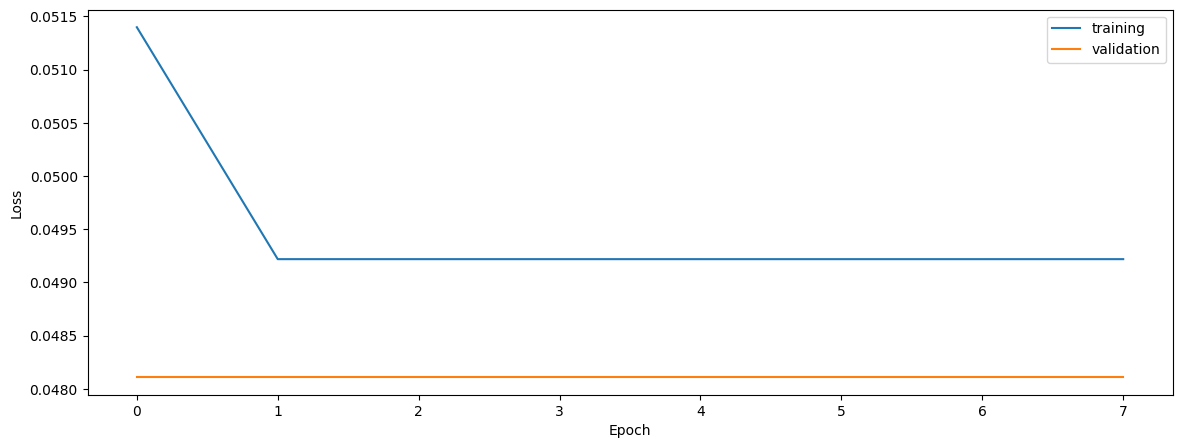

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


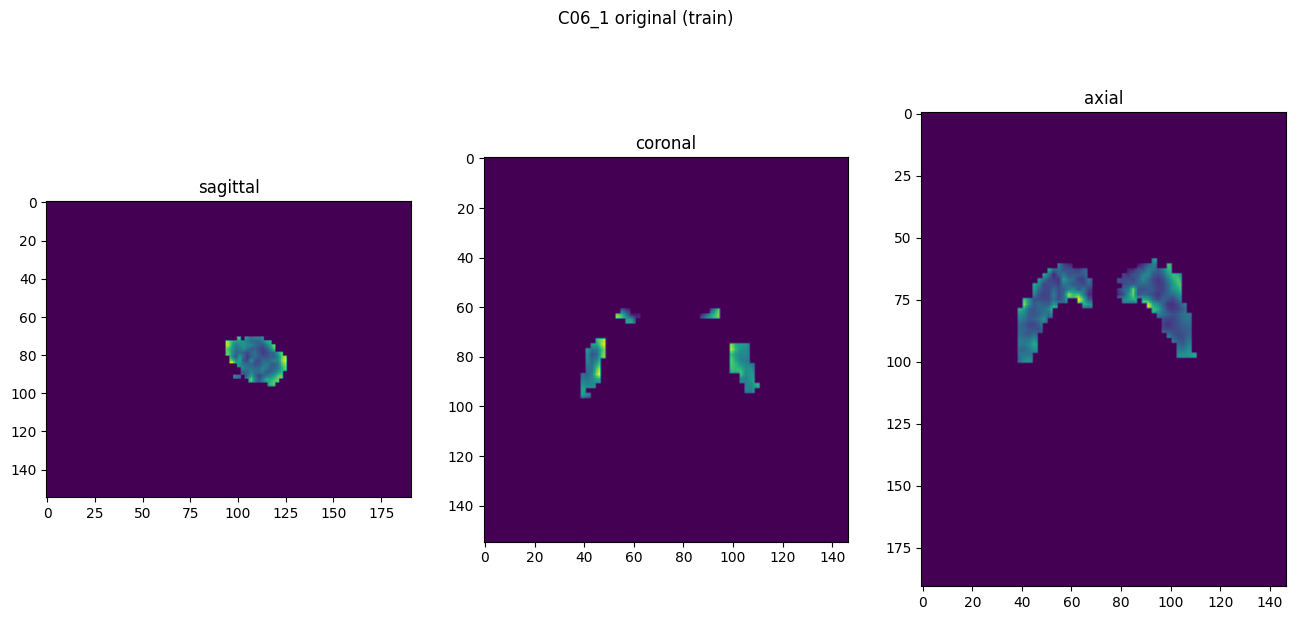

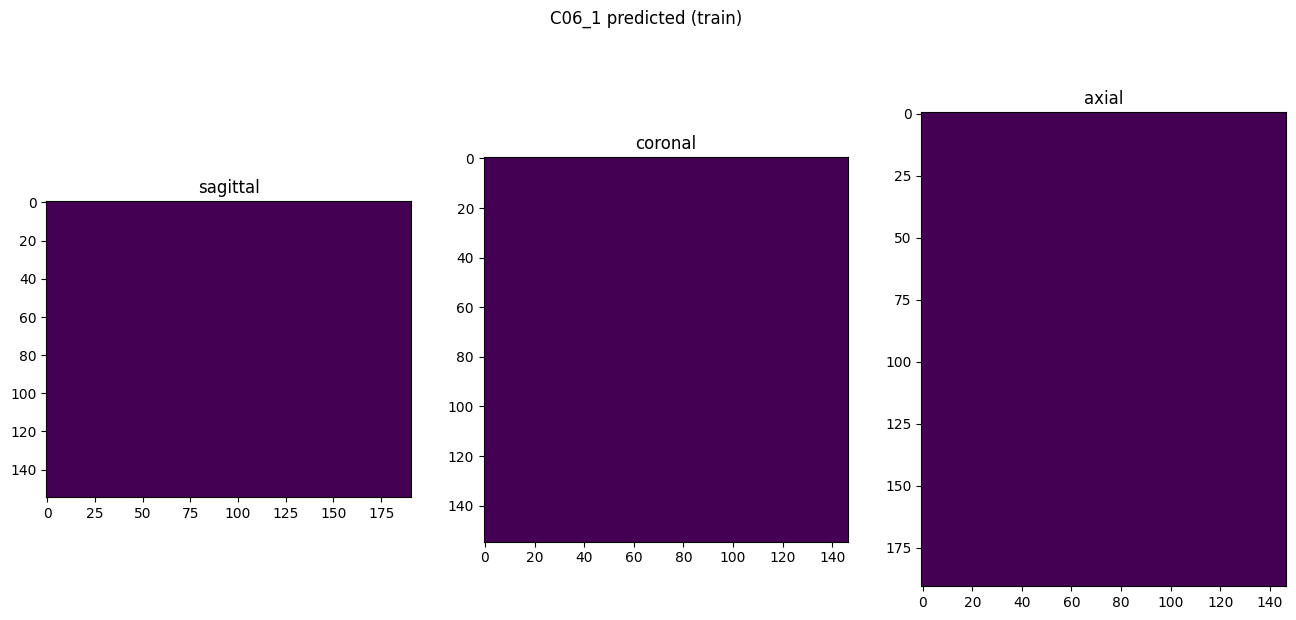

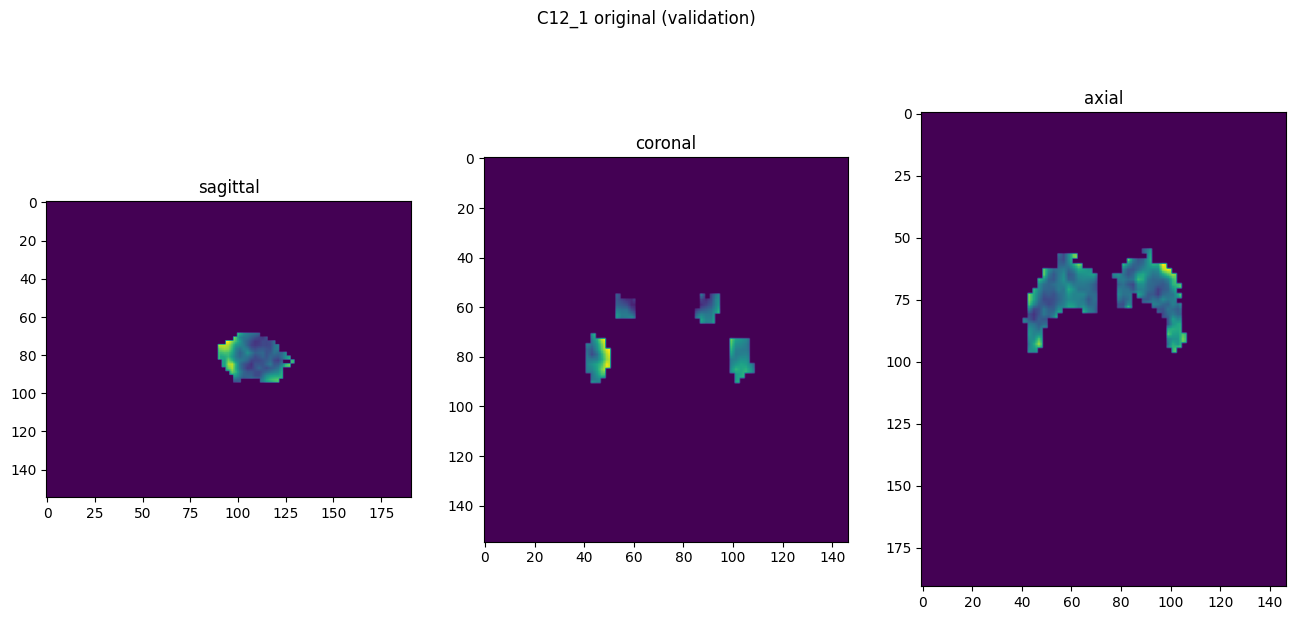

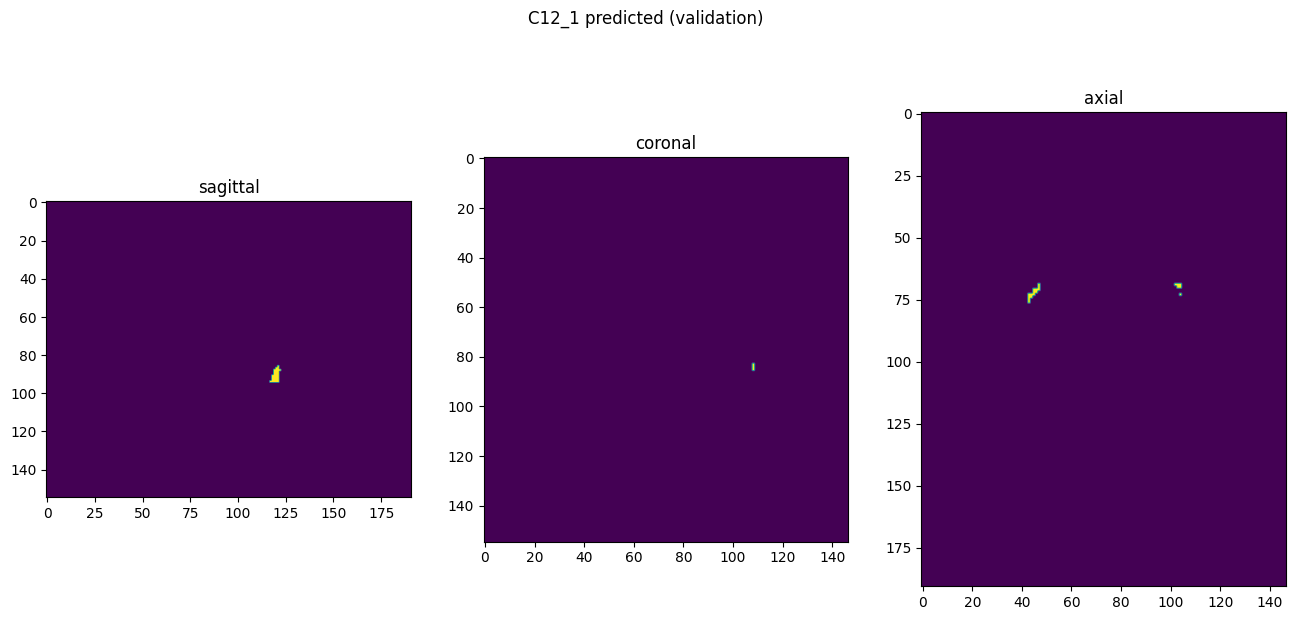

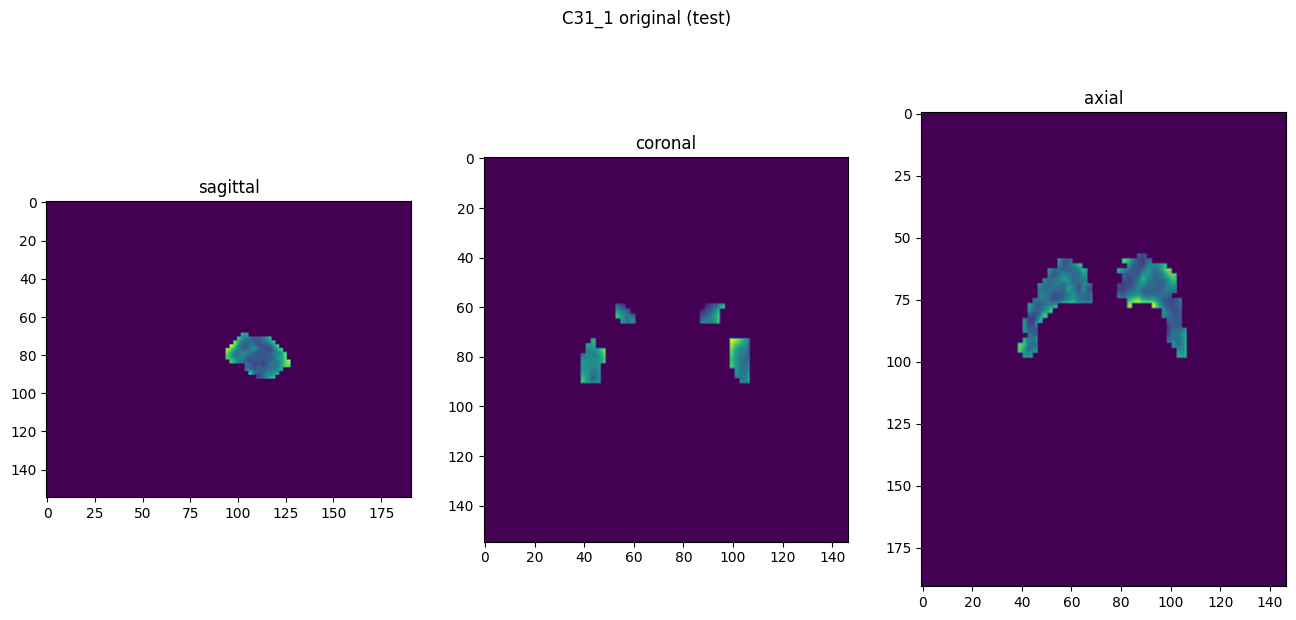

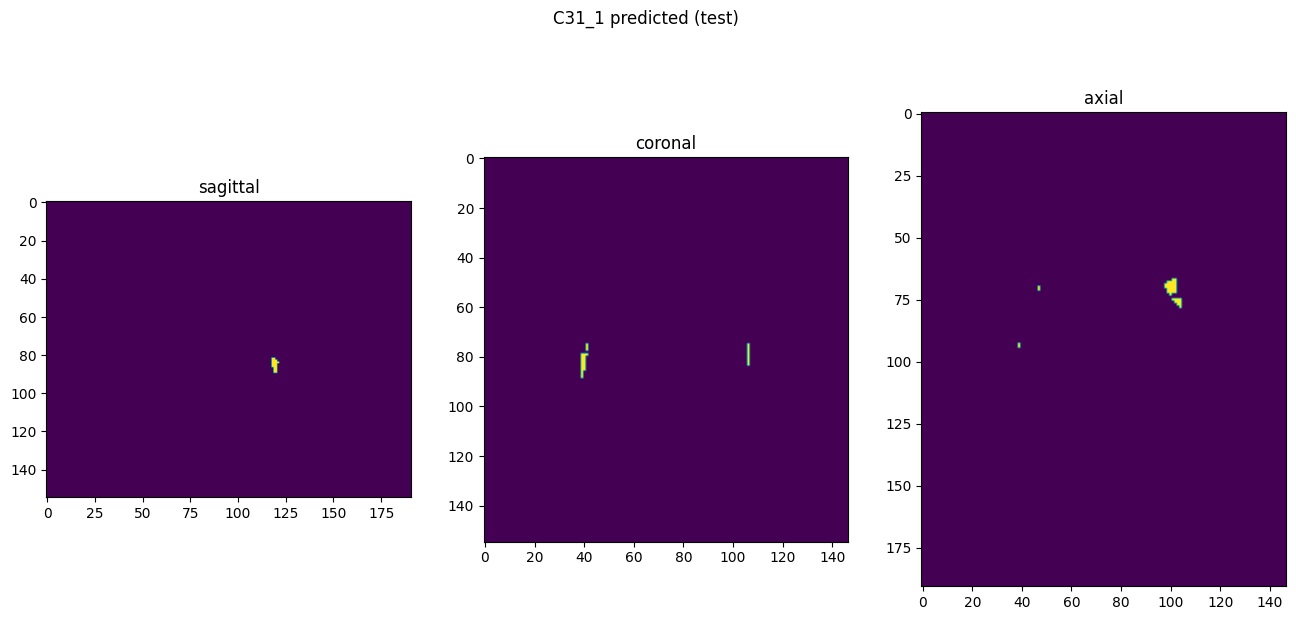

In [10]:
showResults(model, gen, threshold=None, background=False)